In [1]:
import math 
import numpy as np 
from scipy.integrate import quad
import seaborn as snb; snb.set()

In [2]:
def M76_characteristic_function(u, T, r, sigma, lamb, mu, delta): 
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1) 
    value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 
                    + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T) 
    return value

In [3]:
 def M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta): 
        JDCF = M76_characteristic_function(u - 0.5 * 1j, T, r, sigma, lamb, mu, delta) 
        value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * math.log(S0 / K)) * JDCF).real 
        return value

In [4]:
def M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta): 
    int_value = quad(lambda u: M76_integration_function(u, S0, K, T, r, 
                        sigma, lamb, mu, delta), 0, 50, limit=250)[0] 
    call_value = S0 - np.exp(-r * T) * math.sqrt(S0 * K) / math.pi * int_value 
    return call_value

In [5]:
S0 = 100.0 # initial index level 
K = 100.0 # strike level 
T = 1.0 # call option maturity 
r = 0.05 # constant short rate 
sigma = 0.4 # constant volatility of diffusion 
lamb = 1.0 # jump frequency p.a. 
mu = -0.2 # expected jump size 
delta = 0.1 # jump size volatility
print("Value of Call Option %8.3f" % 
      M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta)) 

Value of Call Option   19.948


In [6]:
from math import log, sqrt, exp
from scipy import stats
from scipy.optimize import fsolve

class call_option(object):
    ''' Class for European call options in BSM Model.
    
    Attributes
    ==========
    S0 : float
        initial stock/index level
    K : float
        strike price
    t : datetime/Timestamp object
        pricing date
    M : datetime/Timestamp object
        maturity date
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term
        
    Methods
    =======
    value : float
        return present value of call option
    vega : float
        return vega of call option
    imp_vol : float
        return implied volatility given option quote
    '''
    
    def __init__(self, S0, K, t, M, r, sigma):
        self.S0 = float(S0)
        self.K = K
        self.t = t
        self.M = M
        self.r = r
        self.sigma = sigma

    def update_ttm(self):
        ''' Updates time-to-maturity self.T. '''
        if self.t > self.M:
            raise ValueError("Pricing date later than maturity.")
        self.T = (self.M - self.t).days / 365.

    def d1(self):
        ''' Helper function. '''
        d1 = ((log(self.S0 / self.K)
            + (self.r + 0.5 * self.sigma ** 2) * self.T)
            / (self.sigma * sqrt(self.T)))
        return d1
        
    def value(self):
        ''' Return option value. '''
        self.update_ttm()
        d1 = self.d1()
        d2 = ((log(self.S0 / self.K)
            + (self.r - 0.5 * self.sigma ** 2) * self.T)
            / (self.sigma * sqrt(self.T)))
        value = (self.S0 * stats.norm.cdf(d1, 0.0, 1.0)
            - self.K * exp(-self.r * self.T) * stats.norm.cdf(d2, 0.0, 1.0))
        return value
        
    def vega(self):
        ''' Return Vega of option. '''
        self.update_ttm()
        d1 = self.d1()
        vega = self.S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(self.T)
        return vega

    def imp_vol(self, C0, sigma_est=0.2):
        ''' Return implied volatility given option price. '''
        option = call_option(self.S0, self.K, self.t, self.M,
                             self.r, sigma_est)
        option.update_ttm()
        def difference(sigma):
            option.sigma = sigma
            return option.value() - C0
        iv = fsolve(difference, sigma_est)[0]
        return iv

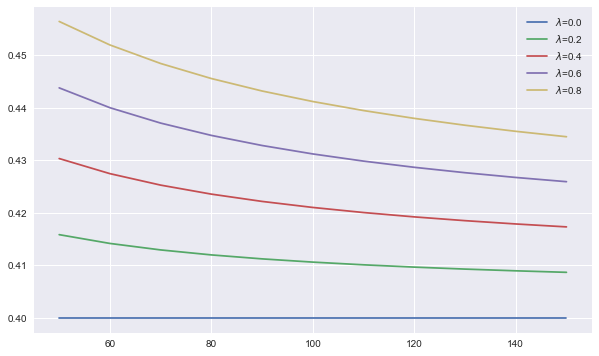

In [7]:
## Generating a volatility smile
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
start = pd.Timestamp('2015-1-1') 
end = pd.Timestamp('2016-1-1') 
strikes = range(50, 151, 10) 
plt.figure(figsize=(10, 6)) 
#l is the lambda which is the intensity o Poisson distribution
for l in np.arange(0, 1.0, 0.2): 
    imp_vols = [] 
    for k in strikes: 
        call = call_option(S0, k, start, end, r, 0.2) 
        M76_value = M76_value_call_INT(S0, k, T, r, sigma, l, mu, delta) 
        imp_vols.append(call.imp_vol(M76_value)) 
    plt.plot(strikes, imp_vols, label='$\lambda$=%2.1f' % l) 
plt.legend(loc=0)  #add labels in the figure
#plt.savefig('vol_smile.png')

In [8]:
## Calibration
C0 = M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta) 
def error_function(p0): 
    sigma, lamb, mu, delta = p0 
    return abs(C0 - M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))

In [9]:
def plot_error_function(): 
    plt.figure(figsize=(10, 6)) 
    # Plotting (lamb) 
    l = np.linspace(-0.5, 1.5, 100); EFv = [] #error function value
    for i in l: 
        EFv.append(error_function([sigma, i, mu, delta])) 
    plt.plot(l, EFv, label='lambda') 
    plt.xlabel('parameter values') 
    plt.ylabel('error function values c.p.') 
    # Plotting (mu) 
    l= np.linspace(-0.3, 0.3, 100); EFv = [] 
    for i in l: 
        EFv.append(error_function([sigma, lamb, i, delta])) 
    plt.plot(l, EFv, label='mu') 
    # Plotting (delta) 
    l = np.linspace(-0.3, 0.3, 100); EFv = [] 
    for i in l: 
        EFv.append(error_function([sigma, lamb, mu, i])) 
    plt.plot(l, EFv, label='delta')
    plt.legend(loc=0)

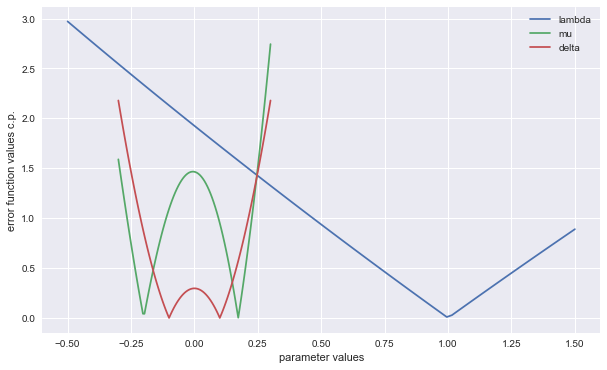

In [10]:
plot_error_function()

In [26]:
h5 = pd.HDFStore('es50_option_data.h5', 'r') 
data = h5['data'] # European call & put option data (3 maturities) 
h5.close() 
S0 = 3225.93 # EURO STOXX 50 level 
r = 0.005 # assumption 

# Option Selection 
tol = 0.05 
options = data[(np.abs(data['Strike'] - S0) / S0) < tol] 
mats = sorted(set(options['Maturity'])) 
options = options[options['Maturity'] == mats[0]]
options["Date"] = options["Date"].apply(lambda x:pd.Timestamp(x))
options["Maturity"] = options["Maturity"].apply(lambda x:pd.Timestamp(x))

In [27]:
options

,Date,Strike,Call,Maturity,Put
452,2014-09-30,3075.0,167.0,2014-10-17,9.3
453,2014-09-30,3100.0,144.5,2014-10-17,11.7
454,2014-09-30,3125.0,122.7,2014-10-17,14.9
455,2014-09-30,3150.0,101.8,2014-10-17,19.1
456,2014-09-30,3175.0,82.3,2014-10-17,24.5
457,2014-09-30,3200.0,64.3,2014-10-17,31.5
458,2014-09-30,3225.0,48.3,2014-10-17,40.5
459,2014-09-30,3250.0,34.6,2014-10-17,51.8
460,2014-09-30,3275.0,23.5,2014-10-17,65.8
461,2014-09-30,3300.0,15.1,2014-10-17,82.3


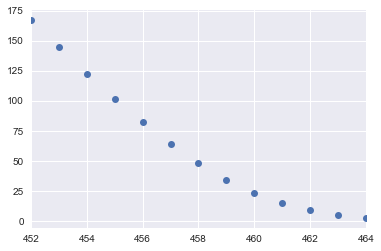

In [13]:
options['Call'].plot(style='o')

In [14]:
## root mean squared error RMSE
i = 0; min_RMSE = 100. 
def M76_error_function(p0): 
    global i, min_RMSE 
    sigma, lamb, mu, delta = p0 
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0: 
        return 500.0 
    se = [] 
    for row, option in options.iterrows(): 
        T = (option['Maturity'] - option['Date']).days / 365. 
        model_value = M76_value_call_INT(S0, option['Strike'], T, 
                                         r, sigma, lamb, mu, delta) 
        se.append((model_value - option['Call']) ** 2) 
    RMSE = math.sqrt(sum(se) / len(se)) 
    min_RMSE = min(min_RMSE, RMSE) 
    if i % 100 == 0: 
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE)) 
    i += 1 
    return RMSE

In [28]:
%%time
#inimize a function over a given range by brute force.
import scipy.optimize as sop
np.set_printoptions(suppress=True,
                   formatter={'all': lambda x:'%6.3f' % x})
#suppress not using the scientific format like e-10
p0 = sop.brute(M76_error_function,((0.10, 0.201, 0.025),
                                   (0.10, 0.80, 0.10), 
                                   (-0.40, 0.01, 0.10),
                                   (0.00, 0.121, 0.02)),
                                   finish=None)
#brute(function,slices)slice(start,stop,step

   0 | [ 0.100  0.100 -0.400  0.000] |  12.676 |  12.676
 100 | [ 0.100  0.300  0.000  0.020] |  15.240 |   7.372
 200 | [ 0.100  0.600 -0.100  0.060] |  11.777 |   2.879
 300 | [ 0.125  0.200 -0.200  0.100] |   9.004 |   2.443
 400 | [ 0.125  0.500 -0.200  0.000] |   5.056 |   1.125
 500 | [ 0.150  0.100 -0.300  0.040] |   6.109 |   0.970
 600 | [ 0.150  0.400 -0.400  0.080] |   4.135 |   0.970
 700 | [ 0.150  0.600  0.000  0.120] |   6.333 |   0.970
 800 | [ 0.175  0.200  0.000  0.020] |   5.955 |   0.970
 900 | [ 0.175  0.500 -0.100  0.060] |   5.536 |   0.970
1000 | [ 0.200  0.100 -0.200  0.100] |   8.596 |   0.970
1100 | [ 0.200  0.400 -0.200  0.000] |  10.692 |   0.970
1200 | [ 0.200  0.700 -0.300  0.040] |  17.578 |   0.970
Wall time: 46.4 s


In [31]:
%%time
#Minimize a function using the downhill simplex algorithm. 
opt = sop.fmin(M76_error_function, p0, xtol=0.00001,                    
               ftol=0.00001, maxiter=750, maxfun=1500) 

1300 | [ 0.122  0.723 -0.247  0.110] |   0.798 |   0.798
1400 | [ 0.119  1.001 -0.187  0.013] |   0.769 |   0.768
1500 | [ 0.119  1.031 -0.183  0.000] |   0.767 |   0.767
1600 | [ 0.119  1.033 -0.183  0.000] |   0.767 |   0.767
Optimization terminated successfully.
         Current function value: 0.766508
         Iterations: 278
         Function evaluations: 477
Wall time: 14.9 s


In [32]:
i=0
M76_error_function(p0)

   0 | [ 0.125  0.600 -0.300  0.120] |   0.970 |   0.767


0.9695219560420907

In [33]:
i=0
M76_error_function(opt)

   0 | [ 0.119  1.033 -0.183  0.000] |   0.767 |   0.767


0.7665083562548161

In [34]:
def generate_plot(opt, options): 
    sigma, lamb, mu, delta = opt 
    options['Model'] = 0.0 
    for row, option in options.iterrows(): 
        T = (option['Maturity'] - option['Date']).days / 365. 
        options.loc[row, 'Model'] = M76_value_call_INT(S0, option['Strike'], 
                                                       T, r, sigma, lamb, mu, delta) 
    options = options.set_index('Strike') 
    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 7)) 
    options[['Call', 'Model']].plot(style=['b-', 'ro'], 
                                    title='%s' % str(option['Maturity'])[:10], ax=ax[0]) 
    ax[0].set_ylabel('option values') 
    xv = options.index.values 
    ax[1] = plt.bar(xv - 5 / 2., options['Model'] - options['Call'], 
                    width=5) 
    plt.ylabel('difference') 
    plt.xlim(min(xv) - 10, max(xv) + 10) 
    plt.tight_layout()

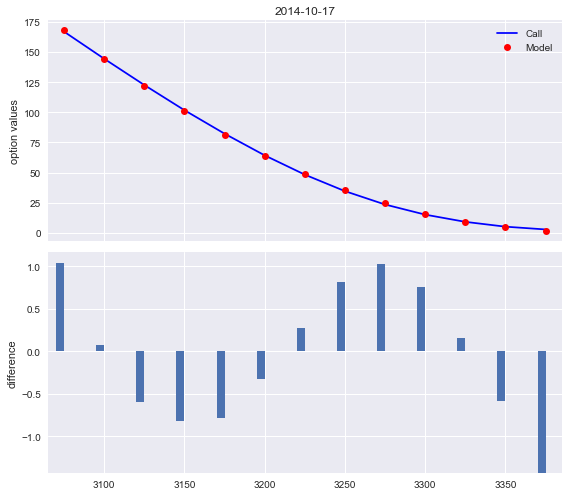

In [35]:
generate_plot(opt,options)

In [36]:
S0 = 3225.93; r = 0.005 
def calc_imp_vols(data): 
    data['Imp_Vol_Mod'] = 0.0 
    data['Imp_Vol_Mar'] = 0.0 
    tol = 0.30 # tolerance for moneyness 
    for row in data.index: 
        t = data['Date'][row] 
        T = data['Maturity'][row] 
        ttm = (T - t).days / 365. 
        forward = np.exp(r * ttm) * S0 
        if (abs(data['Strike'][row] - forward) / forward) < tol: 
            call = call_option(S0, data['Strike'][row], t, T, r, 0.2) 
            data['Imp_Vol_Mod'][row] = call.imp_vol(data['Model'][row]) 
            data['Imp_Vol_Mar'][row] = call.imp_vol(data['Call'][row]) 
    return data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


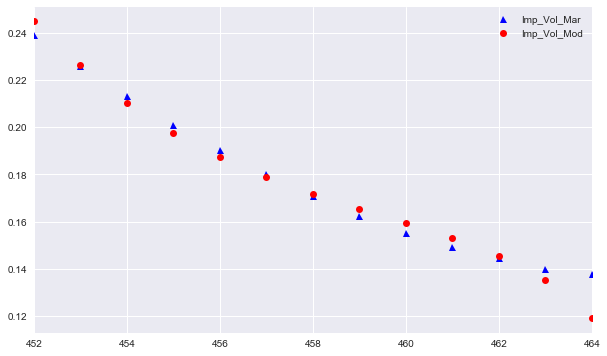

In [37]:
options = calc_imp_vols(options) 
options[['Imp_Vol_Mar', 'Imp_Vol_Mod']].plot(figsize=(10, 6), style=['b^', 'ro'])